In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# veri setini oluşturma

np.random.seed(42)

age = np.random.randint(18, 65, size=1000)
gender = np.random.choice(['male', 'female'], size=1000)
income = np.random.normal(50000, 10000, size=1000)
credit_score = np.random.normal(700, 50, size=1000)
credit_score_usage = np.random.normal(5000, 2000, size=1000)
savings_balance = np.random.normal(20000, 5000, size=1000)

data = pd.DataFrame({
    'age':age, 'gender':gender, 'income':income,
    'credit_score':credit_score, 'credit_card_usage':credit_score_usage,
    'savings_balance':savings_balance
})

data_copy = data.copy()

data.head()

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,56,male,44448.004733,638.522520,6738.309185,23357.655859
1,46,female,68811.570694,724.834961,4088.920948,27640.156797
2,32,female,35519.860996,676.734477,3221.518344,24437.519837
3,60,female,28011.940434,694.702582,6910.601116,23804.233272
4,25,male,54400.144501,832.217167,6752.093585,20300.429973


# Veri Analizi

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1000.0,40.986000,13.497852,18.000000,29.000000,42.000000,52.000000,64.000000
income,1000.0,50568.493322,10006.121202,20786.495165,43847.361028,50420.970688,57198.103225,81931.075678
credit_score,1000.0,700.829006,48.946063,549.024392,668.373805,700.176779,732.836850,896.311885
credit_card_usage,1000.0,4947.756781,2037.603221,-982.271942,3487.930761,4945.440410,6330.099155,11486.185939
savings_balance,1000.0,19750.040977,4985.381825,4116.480934,16586.975199,19952.166574,23171.188531,35760.283673


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                1000 non-null   int32  
 1   gender             1000 non-null   object 
 2   income             1000 non-null   float64
 3   credit_score       1000 non-null   float64
 4   credit_card_usage  1000 non-null   float64
 5   savings_balance    1000 non-null   float64
dtypes: float64(4), int32(1), object(1)
memory usage: 43.1+ KB


In [5]:
# Varyans Analizi
data.var()

C:\Users\murat\AppData\Local\Temp\ipykernel_15128\1282763891.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data.var()


age                  1.821920e+02
income               1.001225e+08
credit_score         2.395717e+03
credit_card_usage    4.151827e+06
savings_balance      2.485403e+07
dtype: float64

In [6]:
# Korelasyon Analizi
data.corr()

,age,income,credit_score,credit_card_usage,savings_balance
age,1.000000,-0.016884,-0.059438,0.084170,-0.006273
income,-0.016884,1.000000,-0.000539,-0.043822,-0.034042
credit_score,-0.059438,-0.000539,1.000000,0.018208,0.027018
credit_card_usage,0.084170,-0.043822,0.018208,1.000000,0.018596
savings_balance,-0.006273,-0.034042,0.027018,0.018596,1.000000


In [7]:
# Eksik Gözlem Analizi
data.isnull().any()

age                  False
gender               False
income               False
credit_score         False
credit_card_usage    False
savings_balance      False
dtype: bool

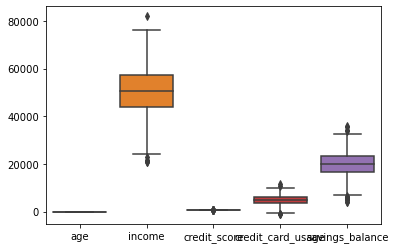

In [8]:
# Aykırı gözlem analizi
sns.boxplot(data=data);

# Veri Ön İşleme

In [9]:
q1, q3 = (data['income'].quantile(0.25), data['income'].quantile(0.75))
iqr = q3 - q1
alt_esik = q1 - 1.5 * iqr
ust_esik = q3 + 1.5 * iqr
data['income'] = np.clip(data['income'], alt_esik, ust_esik)

q1, q3 = (data['credit_score'].quantile(0.25), data['credit_score'].quantile(0.75))
iqr = q3 - q1
alt_esik = q1 - 1.5 * iqr
ust_esik = q3 + 1.5 * iqr
data['credit_score'] = np.clip(data['credit_score'], alt_esik, ust_esik)

q1, q3 = (data['credit_card_usage'].quantile(0.25), data['credit_card_usage'].quantile(0.75))
iqr = q3 - q1
alt_esik = q1 - 1.5 * iqr
ust_esik = q3 + 1.5 * iqr
data['credit_card_usage'] = np.clip(data['credit_card_usage'], alt_esik, ust_esik)

q1, q3 = (data['savings_balance'].quantile(0.25), data['savings_balance'].quantile(0.75))
iqr = q3 - q1
alt_esik = q1 - 1.5 * iqr
ust_esik = q3 + 1.5 * iqr
data['savings_balance'] = np.clip(data['savings_balance'], alt_esik, ust_esik)

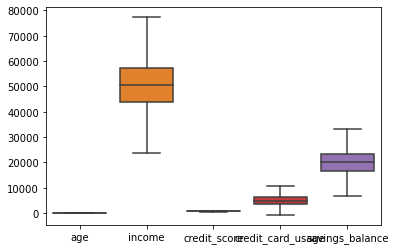

In [10]:
sns.boxplot(data=data);

In [11]:
# Gender kategorik değişkenini sayısal değişkene çevirelim.
data['gender'] = data['gender'].map({'male':0, 'female':1})

In [12]:
# Bağımlı değişkenleri standartlaştıralım.
lbe = StandardScaler()
data['age'] = lbe.fit_transform(data['age'].values.reshape(-1, 1))
data['income'] = lbe.fit_transform(data['income'].values.reshape(-1, 1))
data['gender'] = lbe.fit_transform(data['gender'].values.reshape(-1, 1))
data['credit_score'] = lbe.fit_transform(data['income'].values.reshape(-1, 1))
data['credit_card_usage'] = lbe.fit_transform(data['credit_card_usage'].values.reshape(-1, 1))

In [13]:
data.head(1)

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,1.112882,-0.949284,-0.615496,-0.615496,0.881279,23357.655859


# Model

In [14]:
# Bağımlı ve bağımsız değişkenleri oluşturalım.
X = data.drop('savings_balance', axis=1)
y = data['savings_balance']

In [15]:
# Eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Modeli oluşturalım ve eğitelim.
models = {
    'BaggingRegressor': BaggingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor()
}

for name, model in models.items():
    model = model.fit(X_train, y_train)
    predict = model.predict(X_test)
    r2 = r2_score(y_test, predict)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    print(f'{name} Modeli İçin,\n R^2: {r2}\nMSE: {mse}\nRMSE: {rmse}')
    print('\n')

BaggingRegressor Modeli İçin,
 R^2: -0.13326961274086058
MSE: 25618652.466417465
RMSE: 5061.487179319677


RandomForestRegressor Modeli İçin,
 R^2: -0.07119060314427839
MSE: 24215296.588491973
RMSE: 4920.90404178866


GradientBoostingRegressor Modeli İçin,
 R^2: -0.013374732714920512
MSE: 22908313.082606837
RMSE: 4786.262955856775




### Bu veri seti için default hiperparametreler ile en iyi sonucu GradientBoostingRegresson algoritması verdir. Fakat sonuçlar, bağımsız değişkenlerin bağımlı değişkeni hiç açıklayamadığını gösteriyor. Bu modeli kurduktan hemen sonra standartlaştırma işlemi yapmasaydık sonuç nasıl olurdu sorunu cevaplamak için tekrardan model kuracağız.

# Model Tuning

In [17]:
model = GradientBoostingRegressor()
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [18]:
params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid = GridSearchCV(estimator=model, param_grid=params, cv=5).fit(X_train, y_train)

best_params = grid.best_params_
print('Best Parameters: ', best_params)

Best Parameters:  {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}


In [19]:
model = GradientBoostingRegressor(**best_params).fit(X_train, y_train)
predict = model.predict(X_test)
r2 = r2_score(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = np.sqrt(mse)

print('R^2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

R^2:  -0.003709232595759726
MSE:  22689815.131472304
RMSE:  4763.38274039283


In [20]:
result = pd.DataFrame({
    'Gerçek Değerler': y_test,
    'Tahmin Değerleri': predict
})
result.head()

,Gerçek Değerler,Tahmin Değerleri
521,17512.137508,19855.651693
737,28326.759588,19866.648154
740,23261.530758,19866.648154
660,16932.061973,19711.704731
411,20959.488679,19711.704731


### Şimdi ise bağımsız değişkenleri standartlaştırmadan model oluşturalım.

In [23]:
data_copy.head()

,age,gender,income,credit_score,credit_card_usage,savings_balance
0,56,male,44448.004733,638.522520,6738.309185,23357.655859
1,46,female,68811.570694,724.834961,4088.920948,27640.156797
2,32,female,35519.860996,676.734477,3221.518344,24437.519837
3,60,female,28011.940434,694.702582,6910.601116,23804.233272
4,25,male,54400.144501,832.217167,6752.093585,20300.429973


In [24]:
# Bağımlı ve bağımsız değişkenleri oluşturalım.
X = data_copy.drop(['gender', 'savings_balance'], axis=1)
y = data_copy['savings_balance']

In [25]:
# Eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Modeli oluşturalım ve eğitelim.
model = GradientBoostingRegressor().fit(X_train, y_train)

In [28]:
# Tahmin işlemi yapalım.
predict = model.predict(X_test)

In [29]:
# Modeli Değerlendirelim.
r2 = r2_score(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = np.sqrt(mse)

print('R^2: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

R^2:  -0.04964888744368712
MSE:  24402231.831853904
RMSE:  4939.861519501726


# Sonuç

### Amacımız standartlaştırılmış veri ile standartlaştırılmamış verinin arasındaki farkı incelemekti. Bağımsız değişkenleri standartlaştırdığımız zaman R^2 değeri (-0.003) geldi. Standartlaştırmadığımız zaman ise (-0.04) geldi. Yani veriyi standartlaştırdığımız zaman daha iyi bir model performansı elde edebildik. 

### Tabiki bu performansı incelediğimiz zaman hiç başarılı olmadığını rahatlıkla söyleyebiliriz. Bunun sebebi ise veri setini kendimiz rastgele değerler kullanarak oluşturduk. Gerçek hayat senaryosunu temsil etmiyor. Amacımız, BaggingRegressor, RandomForestRegressor ve GradientBoostingRegressor arasında bir yarışma yapmaktı. Ayrıca standartlaştırılmış verinin performansı ile standartlaştırılmamış verinin performansını da karşılaştırmak istedik. Tüm bu işlemleri yaparken de kullandığımız teknolojileri de pratik etme fırsatı yakalamış olduk. 